<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Import Required Libraries} $

***
</span>
</div>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from IPython.display import Markdown, display

%matplotlib inline

<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Function Definitions} $

***
</span>
</div>

### Correlation Matrix Set Diagonal Zero

In [2]:
def zeroDiagonal(dataTable, dimension):
    ''' Replace Dataframe n x n matrix diagonal values with zero '''
    for i in range(dimension):
        for j in range(dimension):
            if i==j:
                dataTable.iloc[i,j]=0

    return(dataTable)

<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Read Data} $

***
</span>
</div>

## <center> $ \color{darkblue} {\textrm {Read file, add feature names, and examine data with  'describe()'  method} } $

In [3]:
# Load the Adult income dataset to a dataframe and specifiy column names
adultIncome_df = pd.read_csv('../UCI-Adult-Income/adult_data_copy.csv', 
                 header= None, index_col = False,
                 names =['Age',
                         'Workclass',
                         'FNL-Wgt',
                         'Education', 
                         'Education-Years', 
                         'Marital Status',
                         'Occupation',
                         'Relationship',
                         'Race', 
                         'Gender', 
                         'Capital-Gain',
                         'Capital-Loss', 
                         'Hours-per-Week', 
                         'Citizenship',
                         'Income50K'])

<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Data Wrangling} $

***
</span>
</div>

### <span style='color:darkblue'> $ \textrm {Replace '?' with 'Other' and Remove Space Characters} $ </span>

In [4]:
# Replce category name'?' with 'Other'
for col in adultIncome_df.columns:
    if adultIncome_df[col].dtype == 'object':
        adultIncome_df[col]= (adultIncome_df[col].str.strip()).str.replace('?', col+'-Other')

### <span style='color:darkblue'> $ \textrm {Convert Features with Categorical Data to Binary Values} $ </span>

In [5]:
# avoid error if column already removed
if 'Education' in adultIncome_df.columns:
    # remove column 'Education' since it is represented by 'Education-Years'
    adultIncome_df.drop(['Education'], axis = 1, inplace=True)

In [6]:
# Create categorical dummies for binary columns
for col in adultIncome_df.columns:
    # skip over columns with numeric data
    if pd.api.types.is_numeric_dtype(adultIncome_df[col].dtype) == False:  
        # get dummies for each category drop first category to avoid overfitting
        dummies = pd.get_dummies(adultIncome_df[[col]], prefix_sep='_', drop_first = True)
        
        for dcol in dummies.columns:
            # convert to 'category type'
            dm_cat = dummies[dcol].astype('category')
            # insert new columns in the original data frame for analysis
            adultIncome_df.insert(adultIncome_df.columns.get_loc(col), dcol, dm_cat.values)
    
        # remove category column from dataFrame
        adultIncome_df.drop([col], axis=1, inplace=True)

### <span style = 'color:darkblue'> $ \textrm {Pre-Process Training and Test data} $

In [7]:
# decimal places for rounding numbers
decimals = 2

# Feature columns - remove target columns from column list
feature_column_names = [c for c in adultIncome_df.columns if c!='Income50K_>50K']
target_column_name = 'Income50K_>50K'

# Use all features
X_data = adultIncome_df[feature_column_names] 
Y_data = adultIncome_df[[target_column_name]] 

# split data for training and test
X_train_data, X_test_data, Y_train_data, Y_test_data = train_test_split(X_data, \
                                                                        Y_data, \
                                                                        test_size = 0.0017, \
                                                                        random_state = 42)
SampleSize = X_test_data.shape[0]
featureCount = len(adultIncome_df.columns) - 1
print('Observations:     %d\nFeature Count:     %d' % (SampleSize, featureCount))


Observations:     56
Feature Count:     85


<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Exploratory Data Analysis - Inferential Statistics} $

***
</span>
</div>

### <span style = 'color:darkblue'> $ \textrm {Correlation of Features with Categorical Data Converted to Binary Values} $

In [8]:
corrHiVal = pd.DataFrame()
corrLst = []
trainData = pd.get_dummies(X_train_data, drop_first = True).corr()
trainData = zeroDiagonal(trainData, len(trainData))

for i in range(trainData.shape[0]):
    for j in range(i,trainData.shape[1]):
        if np.abs(trainData.iloc[i][j]) > 0.5:
            corrLst.append([np.round(trainData.iloc[i][j], 4), \
                            trainData.index[i], trainData.columns[j]])
            corrHiVal = corrHiVal.append(corrLst)
            
corrHiVal.columns = ['Correlation Value', 'Feature', 'Feature Covariant']
# remove duplicates and sort by values
corrHiVal = corrHiVal.drop_duplicates().sort_values(by = ['Correlation Value'], ascending = False)
_ = corrHiVal.set_index('Feature')

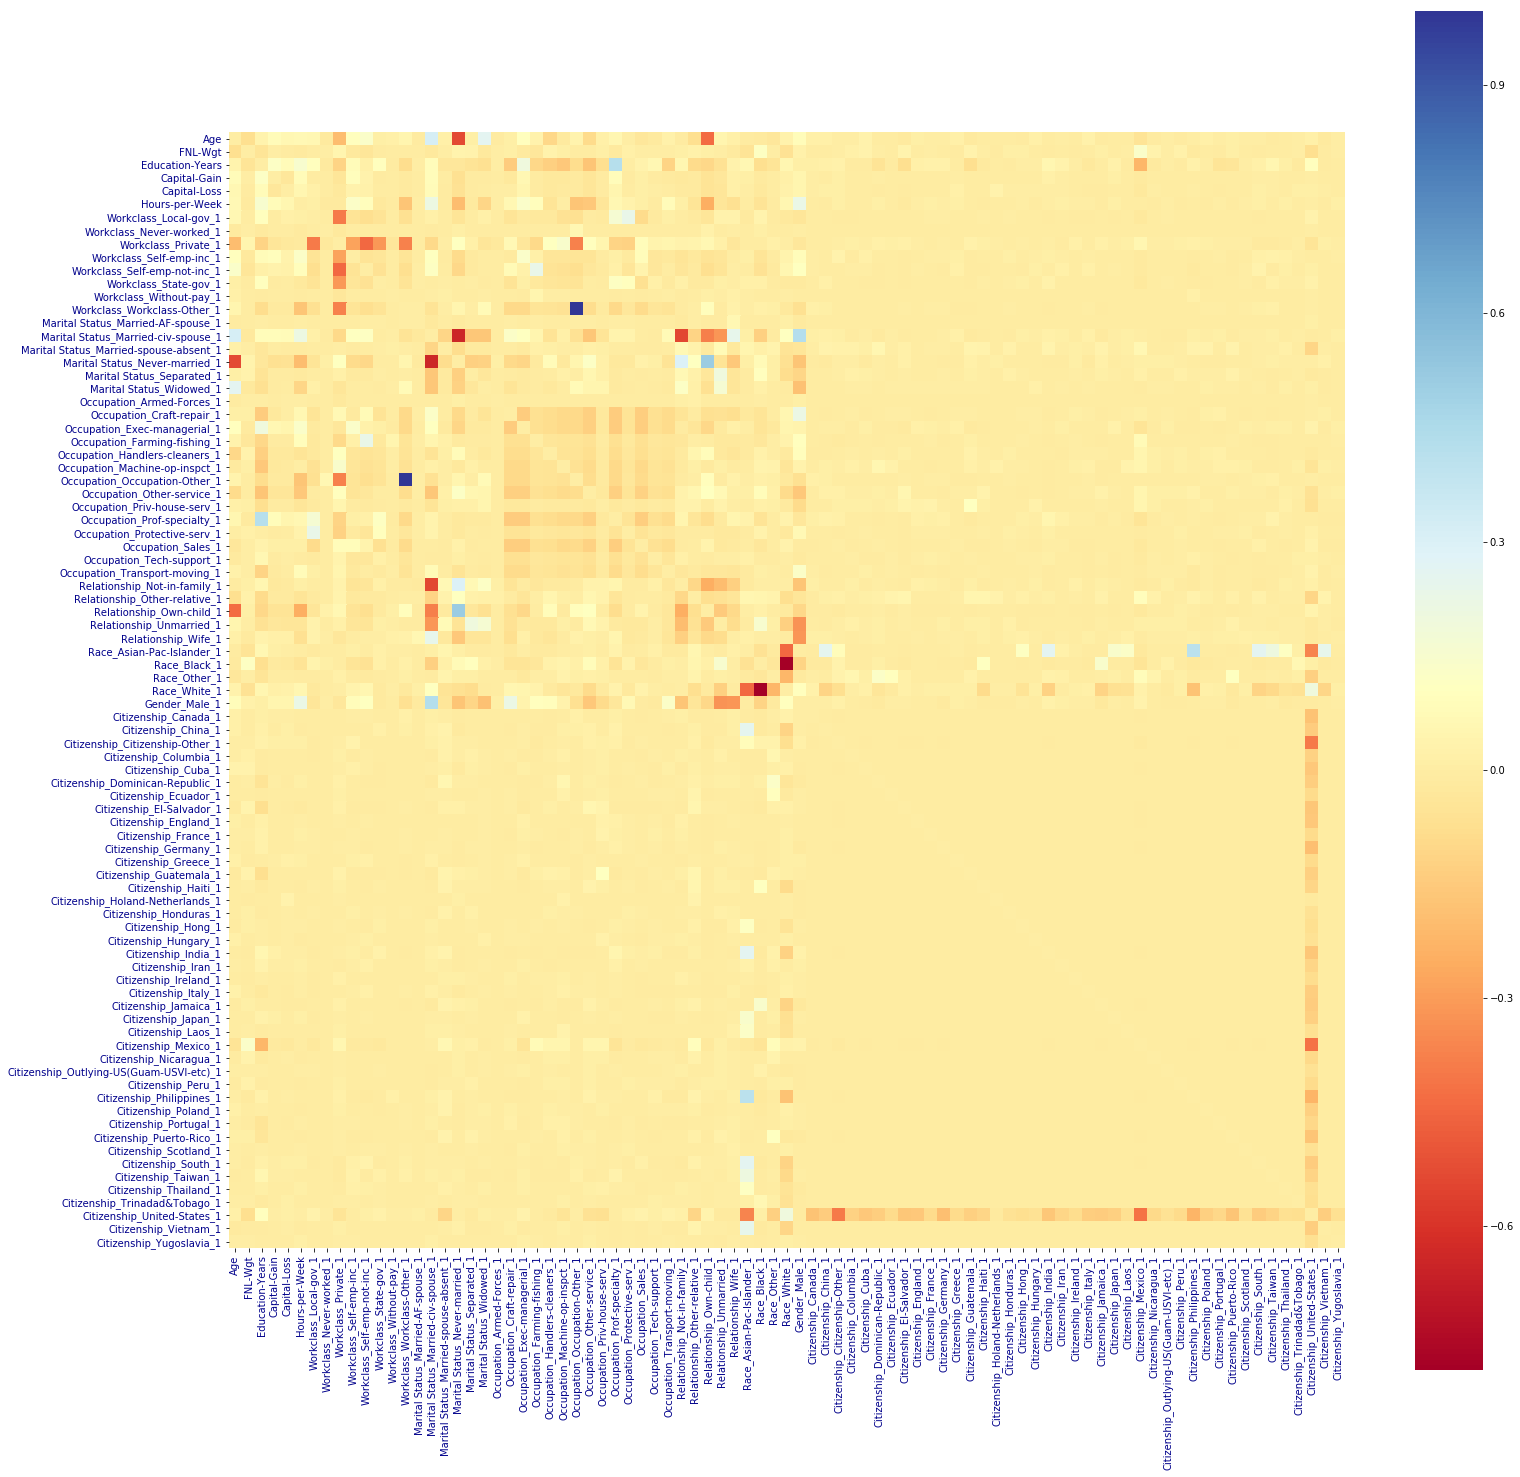

$ \color {darkblue} {\textrm {Feature correlation reveals highly correlated features which may cause overfitting}} $

$ \color {darkblue} {\textrm {Some of the correlation here such as Occupation-Other and Workclass-Other may indicate redundant features as the descriptions may imply. }} $

,Correlation Value,Feature,Feature Covariant
1,0.9980,Workclass_Workclass-Other_1,Occupation_Occupation-Other_1
4,0.5097,Marital Status_Never-married_1,Relationship_Own-child_1
0,-0.5345,Age,Marital Status_Never-married_1
3,-0.5376,Marital Status_Married-civ-spouse_1,Relationship_Not-in-family_1
2,-0.6451,Marital Status_Married-civ-spouse_1,Marital Status_Never-married_1
5,-0.7887,Race_Black_1,Race_White_1


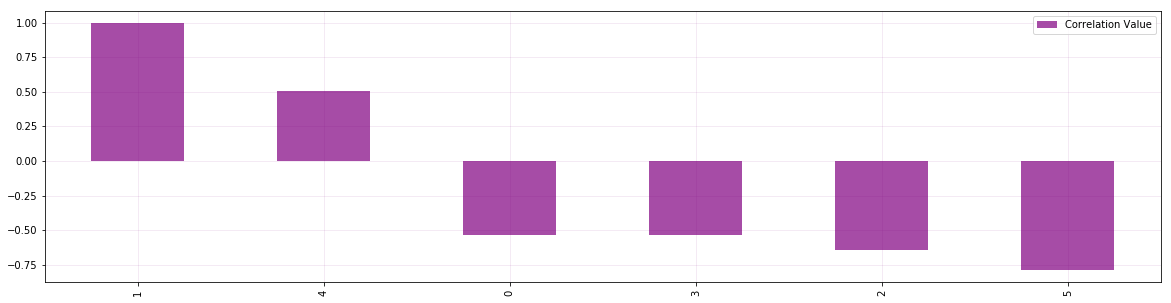

In [9]:
_ = plt.figure(figsize = (25,25))
# Binary Feature Correlation Analysis
_ = sns.heatmap(trainData, square = True, cmap='RdYlBu')
_ = plt.xticks(color = 'darkblue')
_ = plt.yticks(color = 'darkblue')
_ = plt.show()
display(Markdown(r'$ \color {darkblue} {\textrm {Feature correlation reveals highly correlated features which may cause overfitting}} $'))
display(Markdown(r'$ \color {darkblue} {\textrm {Some of the correlation here such as Occupation-Other and Workclass-Other may indicate redundant features as the descriptions may imply. }} $'))
display(corrHiVal)
_ = corrHiVal.plot.bar(figsize = (20,5), color = 'purple', alpha = 0.7)
_ = plt.grid(alpha=0.1, color='purple')

***
$ \color{darkblue} {\large {\textrm {Exploring Categorical Features Related to Target with } }} \color{darkred} {\Large \chi2 } $
***

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import RFECV

In [11]:
# Copy categorical features for Chi2 analysis
cat_trainData = X_test_data.copy()
# Remove numerical features and tabulate categorical features
cat_trainData.drop(['Age', 'FNL-Wgt', 'Education-Years', \
                    'Capital-Gain', 'Capital-Loss', 'Hours-per-Week'], \
                   axis = 1, inplace = True)

$\color{darkblue} {\textrm {Features with best } {\bf\;\chi2\;} \textrm {statistics are considered most relevant.}} $

$\color{darkblue} {\textrm {From the calculations, about 35 features out of 85 have none-negative statistics, with married marital status on top of the list.}} $

,$\color{darkred} {\large \;\chi2} {\large \textrm {-Statistics }} $,$ {\large \textrm {P-Value}} $
Citizenship_United-States,0.000500,0.982155
Workclass_Self-emp-not-inc,0.006504,0.935722
Relationship_Wife,0.006504,0.935722
Workclass_Private,0.026058,0.871759
Race_White,0.051043,0.821259
Race_Other,0.065583,0.797880
Occupation_Prof-specialty,0.131165,0.717227
Occupation_Other-service,0.313279,0.575675
Citizenship_Mexico,0.365854,0.545273
Citizenship_El-Salvador,0.365854,0.545273


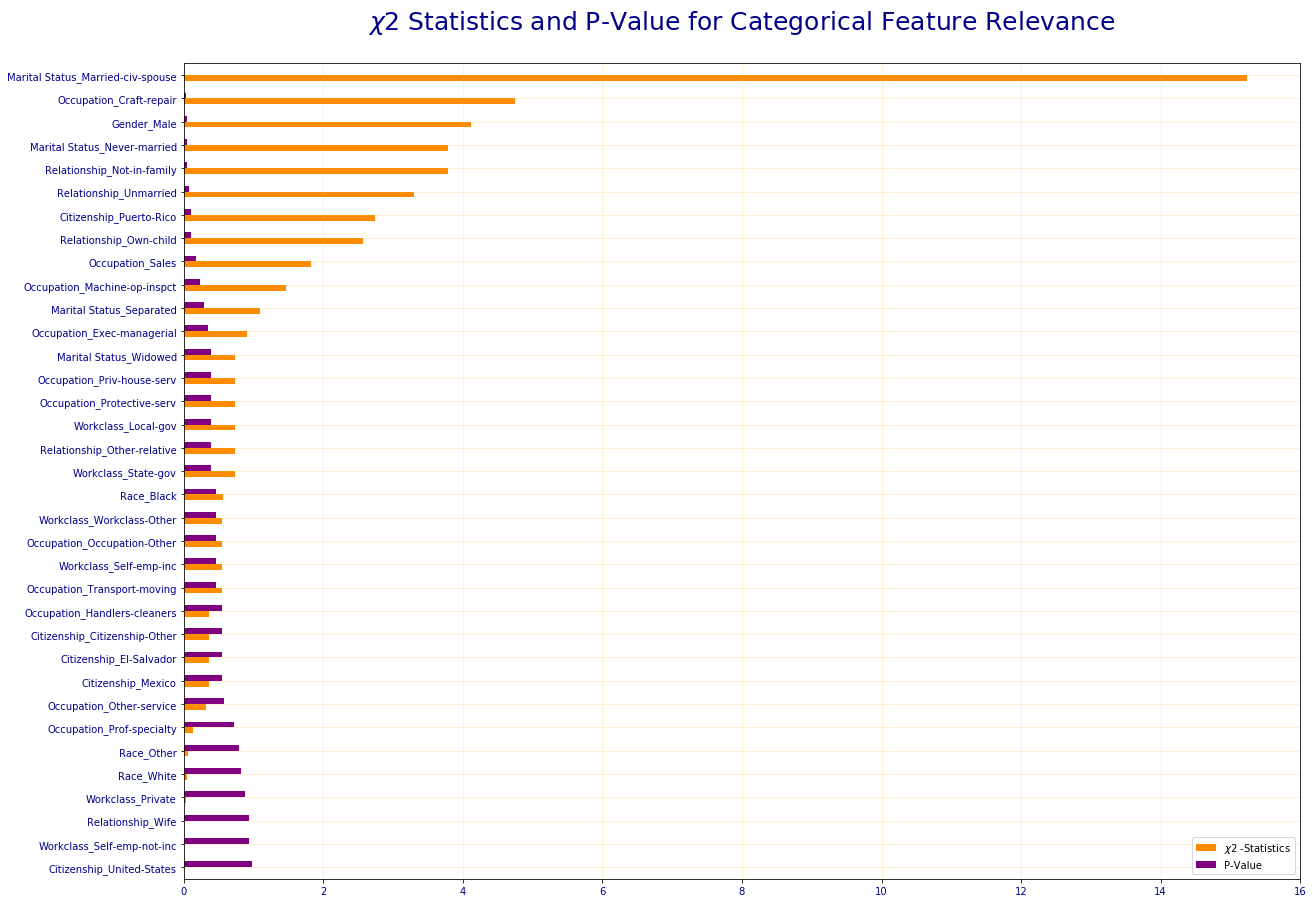

In [17]:
# Apply chi2 on categorical features
chi2_stat, chi2_P_value = chi2(cat_trainData, Y_test_data)

# Tabulate Chi2 , drop null values and sort features with highest statistics 
chi2_featureStat = pd.DataFrame(np.transpose([chi2_stat, chi2_P_value]), \
                                index = cat_trainData.columns, \
                                columns = [r'$\color{darkred} {\large \;\chi2} {\large \textrm {-Statistics }} $', \
                                           r'$ {\large \textrm {P-Value}} $']).dropna().sort_values(by = r'$\color{darkred} {\large \;\chi2} {\large \textrm {-Statistics }} $',\
                                                                                                    ascending = True)

display(Markdown(r'$\color{darkblue} {\textrm {Features with best } {\bf\;\chi2\;} \textrm {statistics are considered most relevant.}} $'))
display(Markdown(r'$\color{darkblue} {\textrm {From the calculations, about 35 features out of 85 have none-negative statistics, with married marital status on top of the list.}} $'))
display(chi2_featureStat[0:15])

_ = chi2_featureStat.plot.barh(figsize = (20,15), color = ['darkorange','purple'])
_ = plt.title('$\chi2 $ Statistics and P-Value for Categorical Feature Relevance\n', size = 25, color = 'darkblue')
_ = plt.grid(color = 'orange', alpha = 0.2)
_ = plt.xticks(rotation = 0, color = 'darkblue')
_ = plt.yticks(color = 'darkblue')
_ = plt.legend([r'${\chi2}$ -Statistics', 'P-Value'])
_ = plt.show()

***
$ \color{darkblue} {\large {\textrm {Identifying Numerical Features Related to Target with  } } \; \color{darkred} {\textrm F-Statistics }  } $
***

In [13]:
v_trainData = X_test_data.loc[:, ('Age', 'FNL-Wgt', 'Education-Years', \
                                  'Capital-Gain', 'Capital-Loss', 'Hours-per-Week')]

$\color{darkblue} {\textrm {Numeric features with best F-Statistics are considered most relevant to predicting the target.}} $

$\color{darkblue} {\textrm {From the calculations, all six features have positive statistics, with Hours-per-Week, Age, and Capital-Gain on top of the list.}} $

$\color{darkblue} {\textrm {Although intuitively, Education-Years should be significant for income level, the F-statistic < 1, does not appear to be}} $

$\color{darkblue} {\textrm {statistically related to the target (Income >= 50K). }} $

,$\color{darkred} {\large {\textrm {F-Statistics}}} $,$\color{darkred} {\large {\textrm {P-Value}}} $
Hours-per-Week,6.272639,0.015313
Age,5.337293,0.024723
Capital-Gain,5.026237,0.029096
FNL-Wgt,3.609167,0.062808
Capital-Loss,2.823980,0.098642
Education-Years,0.341869,0.561188


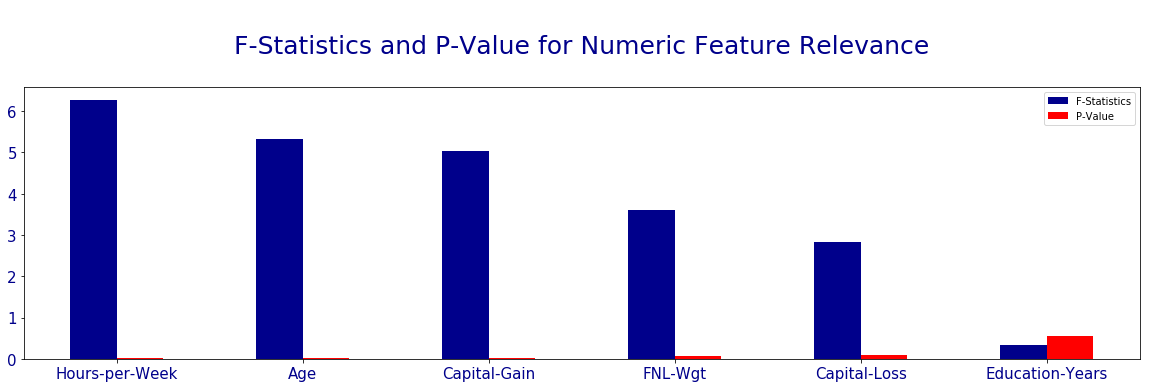

In [16]:
f_stat, f_P_value = f_classif(v_trainData, np.array(Y_test_data)[:,0])
f_selector = SelectKBest(f_classif, k=all)

f_featureStat = pd.DataFrame(np.transpose([f_stat, f_P_value]), \
                             index = v_trainData.columns, \
                             columns = [r'$\color{darkred} {\large {\textrm {F-Statistics}}} $', \
                                        r'$\color{darkred} {\large {\textrm {P-Value}}} $']).sort_values(by = r'$\color{darkred} {\large {\textrm {F-Statistics}}} $', \
                                                                                                        ascending = False)
display(Markdown(r'$\color{darkblue} {\textrm {Numeric features with best F-Statistics are considered most relevant to predicting the target.}} $'))
display(Markdown(r'$\color{darkblue} {\textrm {From the calculations, all six features have positive statistics, with Hours-per-Week, Age, and Capital-Gain on top of the list.}} $'))
display(Markdown(r'$\color{darkblue} {\textrm {Although intuitively, Education-Years should be significant for income level, the F-statistic < 1, does not appear to be}} $'))
display(Markdown(r'$\color{darkblue} {\textrm {statistically related to the target (Income >= 50K). }} $'))

# display F-values
display(f_featureStat)

# bar plot of F-Statistics
_ = f_featureStat.plot.bar(figsize = (20,5), color = ['darkblue', 'red'])

_ = plt.title('\nF-Statistics and P-Value for Numeric Feature Relevance\n', size = 25, color = 'darkblue')
_ = plt.xticks(rotation = 0, color = 'darkblue', size = 15)
_ = plt.yticks(color = 'darkblue', size = 15)
_ = plt.legend(['F-Statistics', 'P-Value'])